In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats

import argus_shapes
import pulse2percept.implants as p2pi

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-05-04 14:31:27,415 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))

In [3]:
subjects = subjectdata.index.sort_values()

In [4]:
features = []
targets = []
for subject in subjects:
    f, t = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'),
                                  subject=subject, amp=2.0, random_state=42)
    xyrange = np.array([np.diff(subjectdata.loc[subject, 'xrange'])[0],
                        np.diff(subjectdata.loc[subject, 'yrange'])[0]])
    t['area'] = [y['area'] / np.prod(x['img_shape']) * np.prod(xyrange)
                 for (_, x), (_, y) in zip(f.iterrows(), t.iterrows())]
    t['orientation'] = np.rad2deg(t['orientation'])
    features.append(f)
    targets.append(t)

In [5]:
Xy = pd.concat((pd.concat(features), pd.concat(targets).drop(columns='electrode')), axis=1)

In [6]:
cols = ['area', 'orientation', 'eccentricity', 'compactness']
ylabels = ['area (deg$^2$)', 'orientation (deg)', 'elongation', 'compactness']
markers = ['o', 's', 'v', '^']
# colors = ['#0072B2', '#009E73', '#D55E00', '#CC79A7']

# Fig. 4A: Shape descriptors

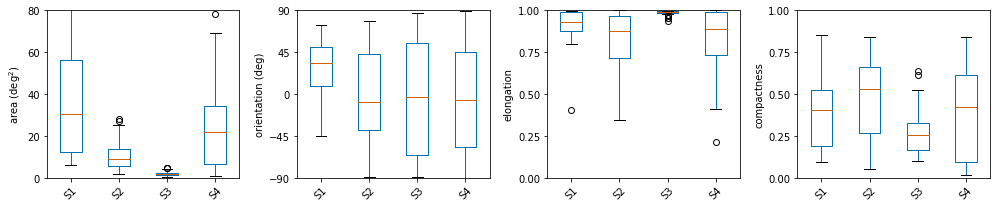

In [7]:
ylimits = [[0, 80], [-90, 90], [0, 1], [0, 1]]

fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim in zip(cols, axes, ylabels, ylimits):
    gb = Xy.loc[:, ['subject', col]].groupby('subject', sort=False)
    gb.boxplot(subplots=False, grid=False, rot=45, ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    ax.set_xticklabels(subjects)
    ax.set_ylabel(ylabel)
fig.tight_layout()
fig.savefig('fig4a-shape-descriptors.eps')

# Fig. 4B: Shape variability

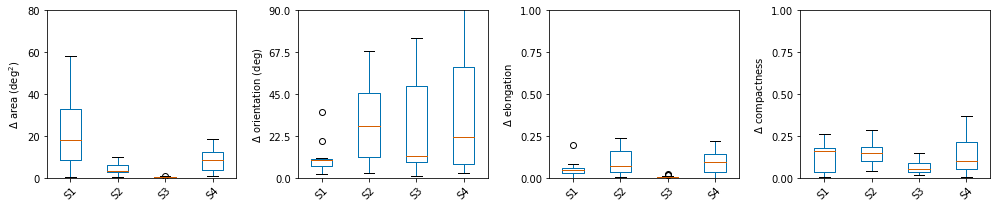

In [8]:
ylimits = [[0, 80], [0, 90], [0, 1], [0, 1]]

fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 3))
for col, ax, ylabel, ylim in zip(cols, axes, ylabels, ylimits):
    gb = Xy.loc[:, ['subject', 'electrode', col]].groupby(['subject', 'electrode'], sort=False)
    ggb = gb.std().groupby('subject')
    ggb.boxplot(subplots=False, grid=False, rot=45, ax=ax)
    ax.set_ylim(*ylim)
    ax.set_yticks(np.linspace(*ylim, num=5))
    ax.set_xticklabels(subjects)
    ax.set_ylabel('$\Delta$ %s' % ylabel)
fig.tight_layout()
fig.savefig('fig4b-shape-variability.eps')